In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import numpy as np

In [3]:
from collections import OrderedDict

In [4]:
from PIL.Image import Image

In [5]:
import torch
import torch.nn.functional as F
from torch import nn, Tensor
from torchvision import (transforms, datasets)

In [6]:
from fastai.vision import *

## Train Letters classificartion with convolutional neural networkm

#### Prepare data

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

In [ ]:
tfms = transforms.Compose([transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))])

In [16]:
path = Path('data')
path.mkdir(exist_ok=True)

In [ ]:
image_path = path / 'geomnist_dataset'

In [ ]:
# ! cp /content/drive/My\ Drive/datasets/letters/trained_data/geomnist_dataset.zip {path}

In [ ]:
import zipfile
with zipfile.ZipFile(path / 'geomnist_dataset.zip' , 'r') as zip_ref:
    zip_ref.extractall(path)

## Initialize all additional functions at once

In [34]:
class FlattenLayer(nn.Module):
    """Flatten layer"""

    def __init__(self):
        super().__init__()

    def forward(self, x: Tensor) -> Tensor:
        return torch.flatten(x, 1)

In [ ]:
def conv2(ni:int, nf:int): 
    return conv_layer(ni,nf,stride=2)

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf, nf)
        self.conv2 = conv_layer(nf, nf)
        
    def forward(self, x): 
        return x + self.conv2(self.conv1(x))

In [ ]:
??res_block

In [ ]:
def conv_and_res(ni, nf): 
    return nn.Sequential(conv2(ni, nf), res_block(nf))

In [ ]:
def img_loader(img_path:Path):
    with open(img_path, mode='rb') as fl:
        with PIL.Image.open(fl) as img:
            return img.convert('L')

## Prepare data loaders

In [ ]:
train_dataset = datasets.ImageFolder(image_path / 'train_geo', loader=img_loader, transform=tfms)
valid_dataset = datasets.ImageFolder(image_path / 'val_geo', loader=img_loader, transform=tfms)
test_dataset = datasets.ImageFolder(image_path / 'test_geo', loader=img_loader, transform=tfms)

In [ ]:
train_dataset, valid_dataset, train_dataset

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
data = DataBunch(train_loader, valid_loader, test_dl=test_loader)

In [ ]:
loss_func = nn.CrossEntropyLoss()

In [ ]:
learn = Learner(data, model, loss_func=loss_func, metrics=accuracy)

#### Model initialization

In [ ]:
?? Flatten

In [ ]:
input_channels=1

In [ ]:
lower_body = nn.Sequential(OrderedDict([('conv1', nn.Conv2d(input_channels, 32, 3)),
                                        ('bn1', nn.BatchNorm2d(32)),
                                        ('relu1', nn.ReLU(inplace=True)),
                                        ('mxpl1', nn.MaxPool2d(2, 2)),
                                        ('conv2', nn.Conv2d(32, 64, kernel_size=3)),
                                        ('bn2', nn.BatchNorm2d(64)),
                                        ('relu2', nn.ReLU(inplace=True)),
                                        ('mxpl2', nn.MaxPool2d(2, 2)),
                                        ('drop1', nn.Dropout2d(p=0.25))]))

In [ ]:
conv_body = nn.Sequential(OrderedDict([('conv3', nn.Conv2d(64, 128, kernel_size=3)),
                                       ('bn3', nn.BatchNorm2d(128)),
                                       ('relu3', nn.ReLU(inplace=True)),
                                       ('mxpl3', nn.MaxPool2d(2, 2)),
                                       ('drop2', nn.Dropout2d(p=0.25))]))

In [ ]:
linear_body = nn.Sequential(OrderedDict([('flatten', FlattenLayer()),
                                         ('ln1', nn.Linear(2 * 2 * 128, 1024, bias=True)),
                                         ('bn2', nn.BatchNorm1d(1024)),
                                         ('relu3', nn.ReLU(inplace=True)),
                                         ('drop2', nn.Dropout(p=0.25))]))

In [ ]:
class LetterNet(nn.Module):
    """Full double letters network implementation"""

    def __init__(self, input_channels=1, num_classes=33):
        super(LetterNet, self).__init__()
        self.conv_part = body
        self.dub_part = conv_body
        self.fc_part = linear_body
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.conv_part(x)
        x = self.dub_part(x)
        x = self.fc_part(x)
        logits = self.fc(x)

        return logits



In [ ]:
model = LetterNet()

In [ ]:
model

In [ ]:
learn = Learner(data, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

## Train model

#### Find learning rate

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(4, 2e-2)

#### Size dependency

In [ ]:
sz = 32 # 34
x_test = torch.randn(4 , 1, sz, sz)

In [ ]:
model(x_test)

## FastAI for MNIST classifier

In [ ]:
?? conv_layer

In [ ]:
model = nn.Sequential(
    conv2(1, 8),   # 14
    conv2(8, 16),  # 7
    conv2(16, 32), # 4
    conv2(32, 16), # 2
    conv2(16, 33), # 1
    nn.AdaptiveAvgPool2d((1, 1)),
    FlattenLayer()      # remove (1,1) grid
)

In [ ]:
model

#### Adaptive (global) pooling

In [ ]:
sz = 32 # 34
x_test = torch.randn(4 , 1, sz, sz)

In [ ]:
model(x_test)

In [ ]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [ ]:
learn.fit_one_cycle(10, max_lr=0.1)

In [ ]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 33),
    nn.AdaptiveAvgPool2d((1, 1)),
    FlattenLayer()
)

In [ ]:
model

In [ ]:
learn = Learner(data, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

In [ ]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(12, max_lr=0.05)

## Bigger model with residual connections

In [ ]:
model = nn.Sequential(
    conv_and_res(1, 32),
    conv_and_res(32, 64),
    conv_and_res(64, 128),
    conv_and_res(128, 256),
    conv_and_res(256, 512),
    conv2(512, 33),
    nn.AdaptiveAvgPool2d((1, 1)),
    FlattenLayer()
)

In [ ]:
learn = Learner(data, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(4, 2e-2)

In [ ]:
learn.fit_one_cycle(8, 2e-2)

#### Add regularization

In [ ]:
model = nn.Sequential(
    conv_and_res(1, 32),
    conv_and_res(32, 64),
    conv_and_res(64, 128),
    conv_and_res(128, 256),
    conv_and_res(256, 512),
    conv2(512, 1024),
    nn.AdaptiveAvgPool2d((1, 1)),
    FlattenLayer(),
    nn.Linear(1024, 512),
    nn.Dropout(p=0.25),
    nn.Linear(512, 512),
    nn.Dropout(p=0.5),
    nn.Linear(512, 33))

In [ ]:
model

In [ ]:
from utils.logging.time_logger import start_timer

In [ ]:
sz = 32 # 34
x_test = torch.randn(4 , 1, sz, sz)

In [ ]:
tm = start_timer(True, model)
y = model(x_test)
tm.timeit()

In [ ]:
learn = Learner(data, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(28, 2e-2)

## Serialize model

In [ ]:
model_path = path / 'models'
model_path.mkdir(exist_ok=True)

In [ ]:
model = learn.model

In [ ]:
torch.save(model.state_dict(), str(model_path / 'mnist_resnet.pth'))

In [ ]:
state_dict = torch.load(str(path / 'models' / 'mnist_resnet.pth'), map_location='cpu')

In [ ]:
state_dict

## Image search

In [20]:
import cv2

In [8]:
from torch import no_grad
from torch.jit import ScriptModule
from torchvision.models import (resnet34, resnet50, wide_resnet50_2)

In [22]:
size = 256
imsz = 224
IMG_SUFF = {'.jpg', '.jpeg', '.png'}

In [13]:
vec_trsfm = transforms.Compose([ToPILImage(mode='RGB'),
                                transforms.Resize(size),
                                transforms.CenterCrop(imsz),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [14]:
class ToPILImage(object):
    """Convert inout image to PIL image"""

    def __init__(self, mode=None):
        super().__init__()
        self.to_pil = transforms.ToPILImage(mode=mode)

    def convert(self, img: Union[np.ndarray, Image]):
        """
        Converts image to the PIL format
        Args:
            img: inout image

        Returns:
            converted image
        """
        return img if isinstance(img, Image) else self.to_pil(img)

    def __call__(self, *args, **kwargs):
        return self.convert(*args, **kwargs)

    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        if self.to_pil.mode is not None:
            format_string += f'mode={self.to_pil.mode}'
        format_string += ')'
        return format_string


class Img2Vec(object):
    """Model wrapper for image embedding"""

    def __init__(self, backbone: Union[nn.Module, ScriptModule], trfm: transforms, device: str = 'cpu'):
        super().__init__()
        self.device = torch.device(device)
        self.backbone = (backbone.eval() if hasattr(backbone, 'eval') else backbone).to(device)
        self.trfm = trfm

    def preprocess(self, *xs: np.ndarray) -> Tensor:
        """
        Transform data before model
        Args:
            *xs: input data

        Returns:
            processed data for model
        """
        return torch.stack([self.trfm(x) for x in xs]).to(self.device)

    @no_grad()
    def forward(self, *xs: np.ndarray) -> np.ndarray:
        tns = self.preprocess(*xs)
        rts = self.backbone(tns)
        y = rts.cpu().data.numpy()

        return y

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

#### Prepare data

In [17]:
search_path = path / 'search'

In [18]:
dir_paths = [dp for dp in search_path.iterdir() if dp.is_dir()]

In [19]:
dir_paths

[PosixPath('data/search/result'),
 PosixPath('data/search/places'),
 PosixPath('data/search/fortresses'),
 PosixPath('data/search/streets'),
 PosixPath('data/search/charches_small'),
 PosixPath('data/search/churches'),
 PosixPath('data/search/rivers')]

In [24]:
img_pts = [im_pt for dp in dir_paths for im_pt in dp.iterdir() if im_pt.suffix in IMG_SUFF]

In [26]:
def read_img(im_pt):
    img = cv2.imread(str(im_pt), cv2.IMREAD_ANYCOLOR)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    return img

In [27]:
imgs = [read_img(ip) for ip in img_pts]

#### Initialize features extractor

In [29]:
cut = 1

In [30]:
body = wide_resnet50_2(pretrained=True)

In [35]:
net = nn.Sequential(nn.Sequential(*list(body.children())[:-cut]), FlattenLayer())

In [36]:
net

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(6

In [37]:
img_vec = Img2Vec(net, vec_trsfm, device='cpu')

In [44]:
vecs = [img_vec(im)[0] for im in imgs]

In [47]:
vecs[0].shape, len(vecs)

((2048,), 182)

In [65]:
img_vecs = list(zip(imgs, vecs))

In [66]:
img_vecs

[(array([[[254, 255, 255],
          [254, 255, 255],
          [255, 255, 255],
          [255, 255, 253],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
  
         [[254, 255, 255],
          [254, 255, 255],
          [255, 255, 255],
          [255, 255, 253],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
  
         [[254, 255, 255],
          [254, 255, 255],
          [255, 255, 255],
          [255, 255, 253],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
  
         [[254, 255, 255],
          [254, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
  
         ...,
  
         [[255, 255, 255],
          [255, 

#### Compare vectors

In [50]:
from scipy.spatial.distance import cosine

In [63]:
import matplotlib.pyplot as plt

In [56]:
def top_vecs(qi, top_k=5):
    qv = img_vec(qi)[0]
    resul_pts = [(cosine(qv, vc), pt) for pt, vc in img_vecs]
    resul_pts = sorted(resul_pts, key=lambda x: x[0], reverse=False)
    resul_pts = resul_pts[:top_k]
    
    return resul_pts

#### Query images

In [48]:
query_path = path / 'queries'
query_path.mkdir(exist_ok=True)

In [78]:
qim = read_img(query_path / 'st_1.jpeg')

In [79]:
res = top_vecs(qim)

In [80]:
res

[(0.18142104148864746, array([[[142, 104,  81],
          [141, 111,  85],
          [208, 188, 161],
          [199, 185, 156],
          ...,
          [219, 203, 216],
          [ 94,  82,  92],
          [ 63,  58,  64],
          [ 97,  97,  97]],
  
         [[163, 129, 104],
          [162, 135, 108],
          [202, 185, 157],
          [200, 189, 159],
          ...,
          [200, 185, 192],
          [ 91,  80,  86],
          [ 62,  58,  59],
          [ 81,  81,  79]],
  
         [[195, 168, 141],
          [174, 153, 124],
          [182, 167, 138],
          [205, 196, 165],
          ...,
          [119, 105, 104],
          [ 69,  59,  57],
          [ 84,  80,  77],
          [ 98,  99,  94]],
  
         [[166, 145, 116],
          [133, 116,  86],
          [128, 114,  85],
          [144, 135, 104],
          ...,
          [ 81,  66,  59],
          [ 48,  37,  31],
          [ 80,  77,  70],
          [ 98, 100,  95]],
  
         ...,
  
         [[ 50,  51,  

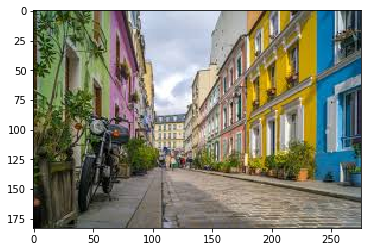

In [81]:
plt.imshow(qim)
plt.show()
plt.close()

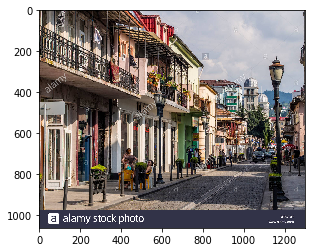

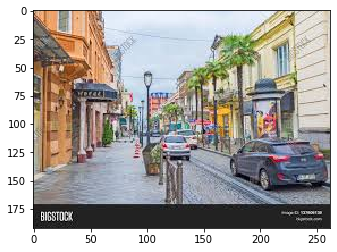

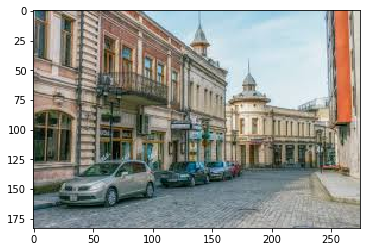

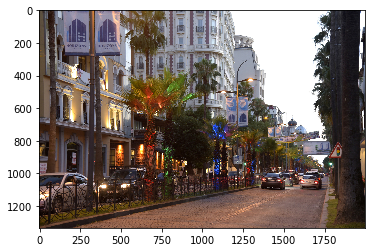

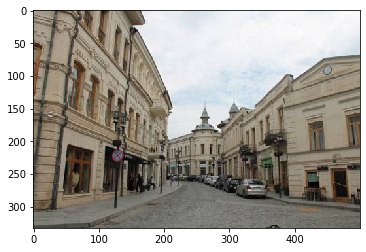

In [82]:
for dist, res_img in res:
    plt.imshow(res_img)
    plt.show()
    plt.close()

## Fine tuning